In [38]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec, StringIndexer, VectorAssembler, DataFrame
from pyspark.sql.functions import col, array, explode, concat_ws, collect_list, udf, lit
import numpy as np 
from pyspark.sql.types import StringType, ArrayType, BooleanType
from datasketch import MinHash, MinHashLSH
from sklearn.cluster import KMeans
from numpy import average

import shutil
import os
import psutil
import time
import matplotlib.pyplot as plt

# All functions used

In [41]:
def shingle(text, k):
    shingle_set = []
    for i in range(len(text)-k +1):
        shingle_set.append(text[i:i+k])
    return set(shingle_set)

def minhash_lsh(df, k_shingle, threshold):

    lsh = MinHashLSH(threshold=threshold, num_perm=128)
    minhashes = {}

    for features in df.collect():
        shingles = shingle(features["features"], k_shingle)
        m = MinHash(num_perm=128)
        for shingle_item in shingles:
            m.update(shingle_item.encode("utf8"))
        minhashes[int(features["user_id"])] = m
        lsh.insert(int(features["user_id"]), m)

    replacement_candidates = {}
    for key in lsh.keys: 
        replacement_candidates[key] = lsh.query(minhashes[key]) 

    #Key: New representative, value: Similar items
    return replacement_candidates

#Iteratively bucket unique processes together
def bucketing(replacement_candidates):
    visited_processes = set()
    new_process_dictionary = {}
    for key, values in replacement_candidates.items():
        new_values = []
        for value in values:
            if value not in visited_processes:
                visited_processes.add(value)
                new_values.append(value)
        if new_values:  # Only add non-empty lists
            new_process_dictionary[key] = sorted(new_values)
    return new_process_dictionary


def kmeans_clustering(df, n_clusters, max_iter):
    minhashes = []
    #for jaccard verification
    minhash_dict = {}
    user_ids = []
    final_buckets = {}
    for features in df.collect():
        shingles = shingle(features["features"], 7)
        m = MinHash(num_perm=128)
        for shingle_item in shingles:
            m.update(shingle_item.encode("utf8"))
        minhashes.append(m.hashvalues)
        minhash_dict[int(features["user_id"])] = m
        user_ids.append(int(features["user_id"]))

    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter).fit(minhashes)

    user_clusters = dict(zip(user_ids, kmeans.labels_))
    final_buckets = {}
    for key, value in user_clusters.items():
        if value in final_buckets:
            final_buckets[value].append(key)
        else:
            final_buckets[value] = [key]

    return final_buckets, minhash_dict


#Get averege jaccard value per bucket

def get_averege_jaccard_sim(final_buckets, minhashes):
    sims = {}
    for key, value in final_buckets.items():
        for user_id_1 in final_buckets[key]:
            for user_id_2 in final_buckets[key]:
                if user_id_1 != user_id_2:
                    sig_1 = minhashes[int(user_id_1)]
                    sig_2 = minhashes[int(user_id_2)]
                    sim = MinHash.jaccard(sig_1, sig_2)
                    if key not in sims:
                        sims[key] = [sim]
                    else:
                        sims[key].append(sim)
    total_sum = 0
    total_count = 0
    sims = dict(sorted(sims.items()))
    for key, value in sims.items():
        avg_sim = average(value)
        print(key, avg_sim)
        total_sum += sum(value)
        total_count += len(value)
    
    overall_average = total_sum / total_count if total_count != 0 else 0
    print("Overall Average Jaccard Similarity:", overall_average)


def write_df(df,file_name):
    os.makedirs('Output', exist_ok=True)
    #temporary folder to save all the temporaty files created by write.csv
    os.makedirs('temp', exist_ok=True)
    df.write.csv('temp/temp_outoput', header=True, mode="overwrite")
    part_file = [f for f in os.listdir('temp/temp_outoput') if f.startswith("part-")][0]

    shutil.move(os.path.join('temp/temp_outoput', part_file), file_name)
    shutil.rmtree('temp/temp_outoput')
    shutil.rmtree('temp')

def output_part1(dataset,k,threshold):
    data = spark.read.csv(dataset, header=True, inferSchema=True)
    df = data.withColumn("arrayColumn", concat_ws("","from", "to")).withColumn("Minhash", lit(""))
    df_grouped = df.groupBy("user_id").agg(
                                            concat_ws("",collect_list("arrayColumn")).alias("features"))
    
    replacement_candidates = minhash_lsh(df_grouped,k,threshold)
    new_process_dictionary = bucketing(replacement_candidates)    

    user_ids = list(new_process_dictionary.keys())
    output_df = data.filter(df.user_id.isin(user_ids))
    final_df = output_df.coalesce(1)
    return write_df(final_df,'Output/part1Output.csv')



def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024  # Convert bytes to MB


def get_cpu_usage(): #cpu
    return psutil.cpu_percent(interval=None)

def get_performance(func1,func2, vals, df_grouped):
    #k_values = [2, 3, 4, 5, 6, 7, 8]
    results = []

    for k in vals:
        start_time = time.time()
        start_mem = get_memory_usage()
        start_cpu = get_cpu_usage()

        replacement_candidates = func1(df_grouped, k, 0.98)
        new_process_dictionary = func2(replacement_candidates)
        
        end_time = time.time()
        end_mem = get_memory_usage()
        end_cpu = get_cpu_usage()

        duration = end_time - start_time
        mem_used = end_mem - start_mem

        results.append({
            'k': k,
            'time_seconds': duration,
            'memory_mb': mem_used,
            'unique_processes': len(new_process_dictionary),
            'cpu': end_cpu
        })
    return results


def plot_results(results):
    k_values = [result['k'] for result in results]
    time_seconds = [result['time_seconds'] for result in results]
    cpu_percentages = [result['cpu'] for result in results]
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('k values')
    ax1.set_ylabel('Time (seconds)', color='tab:blue')
    ax1.plot(k_values, time_seconds, marker='o', color='tab:blue', label='Time')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('CPU Usage (%)', color='tab:red')

    ax2.plot(k_values, cpu_percentages, marker='^', color='tab:red', linestyle='--', label='CPU Usage')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Performance Metrics for Different k Values')
    fig.legend(loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()


def plot_performances(results):
    k_values = [result['k'] for result in results]
    time_seconds = [result['time_seconds'] for result in results]
    cpu_percentages = [result['cpu'] for result in results]

    # Calculate the performance metric (Product of time_seconds and cpu)
    performance_metric = [time_seconds[i] * cpu_percentages[i] for i in range(len(results))]

    # Create a figure and axis
    plt.figure(figsize=(10, 6))

    # Plot the performance metric
    plt.plot(k_values, performance_metric, marker='o', linestyle='-', color='purple', label='Time * CPU')

    # Set labels and title
    plt.xlabel('k values')
    plt.ylabel('Performance Metric (Time * CPU)')
    plt.title('Combined Metric of Time and CPU Usage vs. k Values')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

In [3]:
spark = SparkSession.builder.appName("spark_session_1").getOrCreate()
data = spark.read.csv("data/SDG_dataset2.csv", header=True, inferSchema=True)


df = data.withColumn("arrayColumn", concat_ws("","to")).withColumn("Minhash", lit(""))
df_filtered_m = df.filter(df.type.isin(['Req']))
df_grouped = df_filtered_m.groupBy("user_id").agg(
    concat_ws("",collect_list("arrayColumn")).alias("features"))

## Parameter-tuning for k-shingles

In [20]:
replacement_candidates = minhash_lsh(df_grouped,3, 0.95)
new_process_dictionary = bucketing(replacement_candidates)
print(f"Initial processes: {len(replacement_candidates)}")
print(f"After merging processes: {len(new_process_dictionary)}")

replacement_candidates = minhash_lsh(df_grouped,5,0.95)
new_process_dictionary = bucketing(replacement_candidates)
print(f"Initial processes: {len(replacement_candidates)}")
print(f"After merging processes: {len(new_process_dictionary)}")

replacement_candidates = minhash_lsh(df_grouped,7, 0.95)
new_process_dictionary = bucketing(replacement_candidates)
print(f"Initial processes: {len(replacement_candidates)}")
print(f"After merging processes: {len(new_process_dictionary)}")

Initial processes: 45641
After merging processes: 33572
Initial processes: 45641
After merging processes: 35265
Initial processes: 45641
After merging processes: 35301


## Parameter tuning for Kmeans

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV

minhashes = []
user_ids = []
final_buckets = {}
for features in df_grouped.collect():
    shingles = shingle(features["features"], 5)
    m = MinHash(num_perm=128)
    for shingle_item in shingles:
        m.update(shingle_item.encode("utf8"))
    minhashes.append(m.hashvalues)
    user_ids.append(int(features["user_id"]))

param_grid = {
    'n_clusters': [100, 250, 500, 1000],
    'max_iter': [100, 500, 1000],
}

kmeans = KMeans()

grid_search = GridSearchCV(kmeans, param_grid, cv=5)

grid_search.fit(minhashes)

best_param = grid_search.best_params_
best_model = grid_search.best_estimator_

print("The best parameters are: " , best_param )
print("The best model is: ", best_model)

The best parameters are:  {'max_iter': 100, 'n_clusters': 500}
The best model is:  KMeans(max_iter=100, n_clusters=500)


## STEP 1: Find and merge

In [28]:
replacement_candidates = minhash_lsh(df_grouped,7, 0.95)
new_process_dictionary = bucketing(replacement_candidates)
print(len(replacement_candidates))
print(len(new_process_dictionary))

45641
34772


In [21]:
output_part1("data/SDG_dataset2.csv",7,0.95)

## Performance metrics for k-shingling

In [46]:
results = get_performance(minhash_lsh,bucketing, [3,5,7,9], df_grouped)

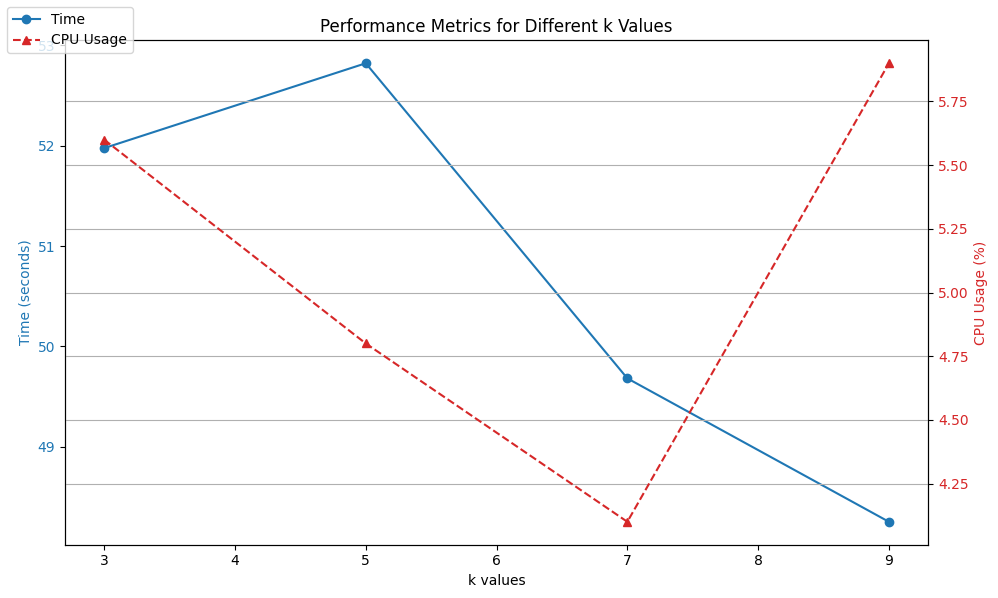

In [47]:
plot_results(results)

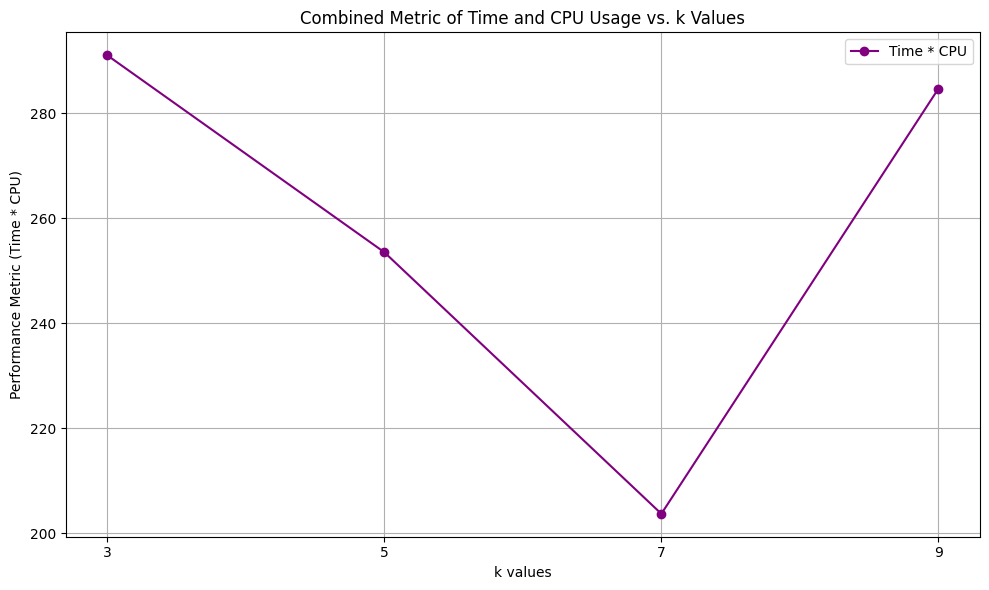

In [48]:
plot_performances(results)

## STEP 2: Find/cluster similar items

In [42]:
from sklearn.model_selection import train_test_split, GridSearchCV

users = []
for key in new_process_dictionary:
    users.append(key)

filtered_df = df_grouped[df_grouped['user_id'].isin(users)]

final_buckets, minhashes = kmeans_clustering(filtered_df,500,1000)

## Verification

In [43]:
get_averege_jaccard_sim(final_buckets, minhashes)

0 1.0
1 0.2644845133754469
2 1.0
3 0.828125
4 0.2058197463768116
5 1.0
6 0.7251674107142857
7 1.0
8 0.9565816326530612
9 1.0
10 1.0
11 1.0
12 1.0
13 0.8300364509246089
14 0.7116198752228164
15 1.0
16 0.8340130649717514
17 0.38995613715783345
18 1.0
19 1.0
20 1.0
21 0.6868055555555556
22 1.0
23 0.20596652122387415
24 1.0
25 1.0
26 1.0
27 0.187501539408867
28 1.0
29 1.0
30 0.3332777883577731
31 1.0
32 0.8994654605263158
33 1.0
34 0.3164618945868946
35 0.875
36 0.9104817708333334
37 1.0
38 1.0
39 0.837231182795699
40 1.0
41 0.9435455192034139
42 0.9675324675324676
43 0.803191154233871
44 0.3726623062015504
45 1.0
46 0.7914926589567866
47 1.0
48 0.16967710923827944
49 0.9518115942028985
50 0.27093715393134
51 0.9007206632653061
52 0.8914473684210527
53 0.7822443181818182
54 1.0
55 0.971358751745492
56 0.30276570855614976
57 1.0
58 0.8723958333333334
59 1.0
60 0.39710782353725177
61 1.0
62 0.6840743524514339
63 0.8615451388888888
64 1.0
65 0.63125
66 1.0
67 0.95546875
68 0.9442126269956459


In [50]:
# indexer = StringIndexer(inputCol="features", outputCol="from_to_type_index")
# indexed_data = indexer.fit(actual_routes_feature).transform(actual_routes_feature)
# assembler = VectorAssembler(inputCols=["from_to_type_index"], outputCol="vector")
# actual_feature_data = assembler.transform(indexed_data)

# actual_feature_data.show()
# # def is_non_zero_vector(vector):
# #     return vector.numNonzeros() > 0

# # is_non_zero_vector_udf = udf(is_non_zero_vector, BooleanType())

# # filtered_data = actual_feature_data.filter(is_non_zero_vector_udf(col("vector")))


# mh = MinHashLSH(inputCol="vector", outputCol="hashes", numHashTables=5, seed=1003)
# model = mh.fit(actual_feature_data)

# #transformed_filtered_data = model.transform(actual_feature_data).head()
# test = model.approxNearestNeighbors()

# # transformed_filtered_data.show(truncate=False, n=50)


# #similar_items.show(truncate=False)

# def is_non_zero_vector(vector):
#     return vector.numNonzeros() > 0

# from collections import defaultdict

# representative_mapping = {}

# group_mapping = defaultdict(list)

# # Iterate over the user neighbors dictionary
# for user, neighbors in new_process_dictionary.items():
#     neighbors_sorted = tuple(sorted(neighbors))
#     if neighbors_sorted in representative_mapping:
#         representative = representative_mapping[neighbors_sorted]
#     else:
#         representative = neighbors_sorted[0]
#         for neighbor in neighbors_sorted:
#             representative_mapping[neighbor] = representative
    
#     representative_mapping[user] = representative
#     group_mapping[representative].append(user)

# new_user_neighbors = {}
# for representative, users in group_mapping.items():
#     new_user_neighbors[representative] = users

# #print(new_user_neighbors)
# new_users = []
# for key, value in new_user_neighbors.items():
#     new_users.append(key)

# print(len(new_users))
# filtered_df = df_grouped[df_grouped['user_id'].isin(new_users)]
# print(f"Amount of processes: {filtered_df.count()}")
#     shingles = shingle(features["features"], 5)
#     m = MinHash(num_perm=128)
#     for shingle_item in shingles:
#         m.update(shingle_item.encode("utf8"))
#     minhashes[int(features["user_id"])] = m
#     lsh.insert(int(features["user_id"]), m)
#     neigbours = lsh.query(m)
#     print(features["user_id"], neigbours)
#     final_buckets[features["user_id"]] = neigbours

# print(final_buckets)